# Example manipulating GX_Simulator output: counts spectrum from photon spectrum
## Please download the data files from [here](https://drive.google.com/drive/folders/1TlkJ4RoDRLIhGxWXoLCCKpD8aMarn1Cq) and read the [accompanying readme.txt](https://drive.google.com/file/d/1uYQ5aEZFd3Z6R-rv-TB-JXWVb4l1GkLv) for more information. The readme contents are replicated in this folder's README.md for convenience.
## Once you download the files you should be able to hit "run all" and see some plots pop up, assuming you have the requirements to run `%matplotlib qt`

In [2]:
# Standard Python packages
import astropy.units as u
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
import astropy.time as atime
from scipy import integrate

# Custom files for reading in Fermi/GBM and STIX data
import fermi_load
import stix_srm_loader

%matplotlib inline

# Fermi case

## Observation time definition and load in the Fermi counts

In [3]:
start, end = atime.Time('2022-03-28T17:12:18'), atime.Time('2022-03-28T17:12:21')
counts_file = 'glg_cspec_n5_220328_v00.pha'
cspec_dat = fermi_load.load_ctime(counts_file)
count_bins = np.concatenate((cspec_dat.energy_bins[:, 0], [cspec_dat.energy_bins[-1, -1]]))

## Get the SRM from the file and get the photon model energy bins

In [4]:
srm_file = 'glg_cspec_n5_bn220328_1709_715_v00.rsp2'
with fits.open(srm_file) as f:
    left_edges = f[2].data['ENERG_LO']
    right_edges = f[2].data['ENERG_HI']
    photon_model_edges = np.concatenate((left_edges, [right_edges[-1]])) << u.keV

    # annoying to find manually so i just hard coded it here
    # you nee dto match up the observing time with the matrix time.
    desired_matrix = f[3+2]
    # Looks good
    print(
        'matrix valid from:', desired_matrix.header['DATE-OBS'],
        'to', desired_matrix.header['DATE-END'])
    print('which completely captures the observing time:', start, end)
    srm = []
    for row in desired_matrix.data['MATRIX']:
        srm.append(row)

    # Last row is just a single element; make it a full one
    # SRM unit is cm2 . ct / ph
    srm[-1] = [0] * len(srm[0]) 
    srm = np.array(srm).astype(float) << u.cm**2 * u.ct / u.ph

matrix valid from: 2022-03-28T17:12:11 to 2022-03-28T17:12:59
which completely captures the observing time: 2022-03-28T17:12:18.000 2022-03-28T17:12:21.000


## Bin the photon model into something compatible with GBM
### Note that there will be edge effects because the photon spectrum has a sharp cutoff

In [5]:
gelu_data = readsav('xray_spectrum.sav')

def gelu_interp(x):
    return np.interp(x, gelu_data['energies'], gelu_data['spectrum'], left=0, right=0)

# Put the flux into a binned scheme which matches the Fermi photon model bins
fermi_binned = np.zeros(photon_model_edges.size - 1)
for i in range(photon_model_edges.size-1):
    ea, eb = photon_model_edges[i], photon_model_edges[i+1]
    flux = integrate.quad(gelu_interp, ea.to_value(u.keV), eb.to_value(u.keV))[0]
    fermi_binned[i] = flux
fermi_binned = np.array(fermi_binned) << u.ph / u.cm**2 / u.s
fermi_binned[fermi_binned <= 0] = 0
fermi_binned /= np.diff(photon_model_edges)

## Plot everything

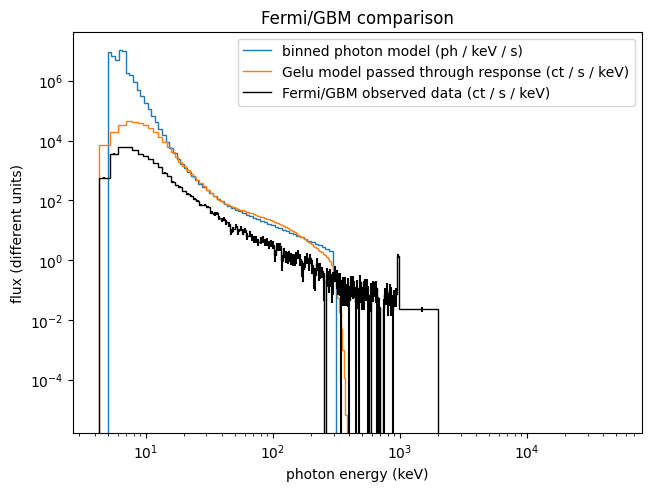

In [6]:
fig, ax = plt.subplots(layout='constrained')
ax.stairs(
    (fermi_load.DETECTOR_AREA * fermi_binned).to_value(u.ph / u.keV / u.s),
    photon_model_edges.to_value(u.keV),
    label='binned photon model (ph / keV / s)'
)

simulated_counts = ((fermi_binned * np.diff(photon_model_edges)) @ srm) / np.diff(count_bins)
ax.stairs(
    simulated_counts,
    count_bins.to_value(u.keV),
    label='Gelu model passed through response (ct / s / keV)'
)

sliced = fermi_load.slice_ctime(cspec_dat, start.datetime, end.datetime)
real_count_rate = np.sum(
    sliced.counts / sliced.dt.sum() / np.diff(count_bins),
    axis=0
)

ax.stairs(
    real_count_rate.to_value(u.ct / u.s / u.keV),
    count_bins.to_value(u.keV),
    label='Fermi/GBM observed data (ct / s / keV)',
    color='black'
)

energy_midpoints = count_bins[:-1] + np.diff(count_bins)/2
real_count_rate_error = np.sum(
    (np.sqrt(sliced.counts.value) << u.ct) / sliced.dt.sum() / np.diff(count_bins),
    axis=0,
)
ax.errorbar(
    energy_midpoints.to_value(u.keV),
    real_count_rate.to_value(u.ct / u.s / u.keV),
    yerr=real_count_rate_error.to_value(u.ct / u.s / u.keV),
    linestyle='None',
    color='black'
)

ax.set(title='Fermi/GBM comparison', xlabel='photon energy (keV)', ylabel='flux (different units)', xscale='log', yscale='log')
ax.legend()

## Note that the above model is off by a scaling factor because the flux has been scaled by Earth/SOLO distance.

# STIX case

## Load in the STIX SRM file

In [7]:
stix_srm = stix_srm_loader.stix_srm_for_sunxspex('stx_srm_2203285726.fits')

In [8]:
photon_model_edges = np.concatenate((
    stix_srm['photon_channel_bins'][:, 0],
    [stix_srm['photon_channel_bins'][-1, -1]]
)) << u.keV
count_bins = np.concatenate((
    stix_srm['count_channel_bins'][:, 0],
    [stix_srm['count_channel_bins'][-1, -1]]
)) << u.keV
gelu_data = readsav('xray_spectrum.sav')

srm = stix_srm['srm'] << u.cm**2 * u.ct / u.ph

def gelu_interp(x):
    return np.interp(x, gelu_data['energies'], gelu_data['spectrum'], left=0, right=0)

# Put the flux into a binned scheme which matches the STIX photon model bins
stix_binned = np.zeros(photon_model_edges.size - 1)
for i in range(photon_model_edges.size-1):
    ea, eb = photon_model_edges[i], photon_model_edges[i+1]
    flux = integrate.quad(gelu_interp, ea.to_value(u.keV), eb.to_value(u.keV))[0]
    stix_binned[i] = flux
stix_binned = np.array(stix_binned) << u.ph / u.cm**2 / u.s
stix_binned[stix_binned <= 0] = 0
stix_binned /= np.diff(photon_model_edges)

## Load in stix data

In [9]:
with fits.open('stx_spectrum_2203285726.fits') as f:
    # Find the observation window
    head = f['rate'].header
    ref = head['MJDREF']
    tzero = head['TIMEZERO']
    time_shift = f['rate'].data['time'] << u.s

    times = atime.Time(atime.Time(ref + tzero, format='mjd') + time_shift, format='iso')
    start, end = atime.Time('2022-03-28T17:12:18'), atime.Time('2022-03-28T17:12:21')

    # Find the time bins closest to the observation times
    nearest = lambda a, v: np.argmin(np.abs(a - v))
    starti, endi = nearest(times, start), nearest(times, end)
    starti, endi

    stix_count_rate = f['rate'].data['rate'][starti:endi].sum(axis=0) << (u.ct / u.s)
    stix_count_rate /= np.diff(count_bins)

    stix_count_rate_error = f['rate'].data['stat_err'][starti:endi].sum(axis=0) << (u.ct / u.s)
    stix_count_rate_error /= np.diff(count_bins)
    stix_count_rate_error[stix_count_rate_error <= 0] = 0

## Plot it

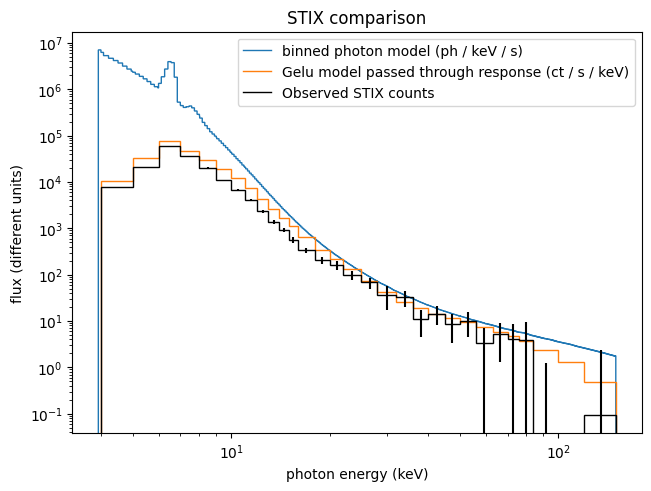

In [10]:
fig, ax = plt.subplots(layout='constrained')

ax.stairs(
    (stix_srm['area'] * stix_binned).to_value(u.ph / u.keV / u.s),
    photon_model_edges.to_value(u.keV),
    label='binned photon model (ph / keV / s)'
)

simulated_counts = ((stix_binned * np.diff(photon_model_edges)) @ srm) / np.diff(count_bins)
ax.stairs(
    simulated_counts,
    count_bins.to_value(u.keV),
    label='Gelu model passed through response (ct / s / keV)'
)

ax.stairs(
    stix_count_rate.to_value(u.ct / u.s / u.keV),
    count_bins.to_value(u.keV),
    label='Observed STIX counts',
    color='black'
)
energy_midpoints = count_bins[:-1] + np.diff(count_bins)/2
ax.errorbar(
    energy_midpoints.to_value(u.keV),
    stix_count_rate.to_value(u.ct / u.s / u.keV),
    yerr=stix_count_rate_error.to_value(u.ct / u.s / u.keV),
    linestyle='None',
    color='black'
)

ax.set(title='STIX comparison', xlabel='photon energy (keV)', ylabel='flux (different units)', xscale='log', yscale='log')
ax.legend()

## In X-ray fitting we often add systematic error onto the counts as follows:
## $\sigma_\text{tot} = \sqrt{\sigma_\text{obs}^2 + (\alpha \cdot c)^2}$, where $\alpha$ is some small percentage (like 5%) and $c$ is the counts in each bin.
## Might be necessary to get agreement with GX_Simulator results.